In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

#Competition Imports
from kaggle.competitions import twosigmanews

['marketdata_sample.csv', 'news_sample.csv']


In [2]:
#####################################
# Libraries
#####################################
# Common libs
import pandas as pd
import numpy as np
import sys
import os
import os.path
import random
from pathlib import Path
from time import time
from itertools import chain

# Image processing
import imageio
import skimage
import skimage.io
import skimage.transform
#from skimage.transform import rescale, resize, downscale_local_mean

# Charts
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBClassifier
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer,StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LSTM, Embedding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

#####################################
# Settings
#####################################
plt.style.use('seaborn')
# Set random seed to make results reproducable
np.random.seed(42)
tensorflow.set_random_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
# Improve printed df readability
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

print(os.listdir("../input"))

['marketdata_sample.csv', 'news_sample.csv']


Using TensorFlow backend.


In [3]:
np.random.seed(42)

env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [4]:
#Reading the competition data
(market, news) = env.get_training_data()

# Set time index at market data
market.time = market.time.astype('datetime64[D, UTC]')
news.time = news.time.astype('datetime64[D, UTC]')

In [5]:
nassets=len(market.assetName.unique().categories)
nrows=market.close.count()

nnews = news.size
nassets = len(news.assetName.cat.categories)

In [6]:
#Dataset Split
market_idx = market[market.time > '2009'][['time', 'assetCode']]
market_idx = market_idx.tail(3000000)
market_train_idx, market_test_idx = train_test_split(market_idx, test_size=0.2, shuffle=False, random_state=24)
market_train_idx, market_val_idx = train_test_split(market_train_idx, test_size=0.25, shuffle=False, random_state=24)

In [7]:
#Market Preprocessor - provided by competition folks: https://www.kaggle.com/bguberfain/a-simple-model-using-the-market-and-news-data#
class MarketPrepro:
    """
    Standard way to generate batches for model.fit_generator(generator, ...)
    Should be fit on train data and used on all train, validation, test
    """
    # Features
    assetcode_encoded = []
    assetcode_train_count = 0
    time_cols=['year', 'week', 'day', 'dayofweek']
    numeric_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
                    'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
                    'returnsOpenPrevMktres10']
    feature_cols = ['assetCode_encoded']  + time_cols + numeric_cols
    
    # Labels
    label_cols = ['returnsOpenNextMktres10']   
    
    def __init__(self):
        self.cats={}
    
    def fit(self, market_train_df):
        """
        Fit preprocessing scalers, encoders on given train df.
        Store given indices to generate batches_from.
        @param market_train_df: train data to fit on
        """
        df = market_train_df.copy()
        # Clean bad data. We fit on train dataset and it's ok to remove bad data
        market_train_df = self.fix_train(market_train_df)
        
        # Extract day, week, year from time
        market_train_df = self.prepare_time_cols(market_train_df)
        
        # Fit for numeric and time
        self.numeric_scaler = StandardScaler()
        self.numeric_scaler.fit(market_train_df[self.numeric_cols + self.time_cols].astype(float))
        
        # Fit asset encoding
        market_train_df = self.encode_asset(market_train_df, True)
        
    def fix_train(self, train_df):
        """
        Remove bad data. For train dataset only
        """
        # Remove strange cases with close/open ratio > 2
        max_ratio  = 2
        train_df = train_df[(train_df['close'] / train_df['open']).abs() <= max_ratio].loc[:]
        # Fix outliers etc like for test set
        train_df = self.safe_fix(train_df)
        return(train_df)

    def safe_fix(self, df):
        """
        Fill na, fix outliers. Safe for test dataset, no rows removed.
        """
        # Fill nans
        df[self.numeric_cols] = df[ ['assetCode'] + self.numeric_cols].groupby('assetCode').transform(lambda g: g.fillna(method='bfill'))
        
        df[self.numeric_cols] = df[self.numeric_cols].fillna(0)
        # Fix outliers
        df[self.numeric_cols] = df[self.numeric_cols].clip(df[self.numeric_cols].quantile(0.01), df[self.numeric_cols].quantile(0.99), axis=1)
        return(df)
    
    def get_X(self,df):
        """
        Preprocess and return X without y
        """
        df = df.copy()
        # Fix bad data without removing rows
        df = self.safe_fix(df)

        # Add day, week, year
        df = self.prepare_time_cols(df)
        # Encode assetCode
        df = self.encode_asset(df, is_train=False)
        # Scale numeric features and labels
        df[self.numeric_cols+self.time_cols] = self.numeric_scaler.transform(df[self.numeric_cols+self.time_cols].astype(float))

        # Return X
        return df[self.feature_cols]
    
    def get_y(self, df):
        y=(df[self.label_cols] >=0).astype(float)
        return y

    def encode_asset(self, df, is_train):
        def encode(assetcode):
            """
            Encode categorical features to numbers
            """
            try:
                # Transform to index of name in stored names list
                index_value = self.assetcode_encoded.index(assetcode) +1
            except ValueError:
                # If new value, add it to the list and return new index
                self.assetcode_encoded.append(assetcode)
                index_value = len(self.assetcode_encoded)

            #index_value = 1.0/(index_value)
            index_value = index_value / (self.assetcode_train_count + 1)
            return(index_value)       
        
        if is_train:
            self.assetcode_train_count = len(df['assetCode'].unique())+1
        df['assetCode_encoded'] = df['assetCode'].apply(lambda assetcode: encode(assetcode))
        return(df)
        
    def prepare_time_cols(self, df):
        """ 
        Extract time parts, they are important for time series 
        """
        df = df.copy()
        df['year'] = df['time'].dt.year
        # Maybe remove month because week of year can handle the same info
        df['day'] = df['time'].dt.day
        # Week of year
        df['week'] = df['time'].dt.week
        df['dayofweek'] = df['time'].dt.dayofweek
        return(df)

market_prepro = MarketPrepro()

In [8]:
#News Preprocessor - provided by competition folks: https://www.kaggle.com/bguberfain/a-simple-model-using-the-market-and-news-data# 
class NewsPrepro:
    """
    Aggregate news by day and asset. Normalize numeric values.
    """
    news_cols_agg = {
        'urgency': ['min', 'count'],
        'takeSequence': ['max'],
        'bodySize': ['min', 'max', 'mean', 'std'],
        'wordCount': ['min', 'max', 'mean', 'std'],
        'sentenceCount': ['min', 'max', 'mean', 'std'],
        'companyCount': ['min', 'max', 'mean', 'std'],
        'marketCommentary': ['min', 'max', 'mean', 'std'],
        'relevance': ['min', 'max', 'mean', 'std'],
        'sentimentNegative': ['min', 'max', 'mean', 'std'],
        'sentimentNeutral': ['min', 'max', 'mean', 'std'],
        'sentimentPositive': ['min', 'max', 'mean', 'std'],
        'sentimentWordCount': ['min', 'max', 'mean', 'std'],
        'noveltyCount12H': ['min', 'max', 'mean', 'std'],
        'noveltyCount24H': ['min', 'max', 'mean', 'std'],
        'noveltyCount3D': ['min', 'max', 'mean', 'std'],
        'noveltyCount5D': ['min', 'max', 'mean', 'std'],
        'noveltyCount7D': ['min', 'max', 'mean', 'std'],
        'volumeCounts12H': ['min', 'max', 'mean', 'std'],
        'volumeCounts24H': ['min', 'max', 'mean', 'std'],
        'volumeCounts3D': ['min', 'max', 'mean', 'std'],
        'volumeCounts5D': ['min', 'max', 'mean', 'std'],
        'volumeCounts7D': ['min', 'max', 'mean', 'std']
            }
    news_cols_numeric = set(news_cols_agg.keys()) - set(['assetCode', 'time'])
        
    def fit(self, news_train_df):
        """
        Fit preprocessing scalers, encoders on given train df.
        @param news_train_df: train data to fit on
        """
        # Fill na with previous value for the asset
        news_train_df = news_train_df.copy()
        #news_train_df = news_train_df.groupby('assetCode').transform(lambda g: g.fillna(method='bfill'))
        
        # Aggregation
        news_train_df_agg = self.aggregate_news(news_train_df)
        news_train_df_agg.fillna(0, inplace=True)
        #news_train_df_agg = news_train_df_agg._get_numeric_data().astype(float)
        
        #Fit scaler
        self.numeric_scaler = StandardScaler()
        self.numeric_scaler.fit(news_train_df_agg)
        # Save news feature cols
        self.feature_cols = list(news_train_df_agg.columns.values)

    def get_X(self, df):
        news_df = df.copy()
        # Fill na with previous value for the asset
        #news_df = df.groupby('assetCode').transform(lambda g: g.fillna(method='bfill'))
        
        # Aggregate by time, asset code
        news_df = self.aggregate_news(df)
        # Normalize, fillna etc. Don't remove rows.
        news_df.fillna(0, inplace=True)
        if not news_df.empty:
            news_df_numeric = news_df._get_numeric_data().astype(float)
            news_df[news_df_numeric.columns] = self.numeric_scaler.transform(news_df_numeric)
        return(news_df)
        
    def aggregate_news(self, df):
        # Fix asset codes (str -> list)
        df['assetCodes'] = df['assetCodes'].str.findall(f"'([\w\./]+)'")    

        # Leave only days in time
        if not df.empty: df.time = df.time.astype('datetime64[D, UTC]') #.tail()
        
        #Expand assetCodes
        assetCodes_expanded = list(chain(*df['assetCodes']))
        
        if(not df.empty): assetCodes_index = df.index.repeat(df['assetCodes'].apply(len)) 
        else: assetCodes_index = df.index
        assert len(assetCodes_index) == len(assetCodes_expanded)
        df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

        # Create expanded news (will repeat every assetCodes' row)
        news_cols = ['time', 'assetCodes'] + sorted(list(self.news_cols_agg.keys()))
        df_expanded = pd.merge(df_assetCodes, df[news_cols], left_on='level_0', right_index=True, suffixes=(['','_old']))

        # Aggregate numerical news features
        df_aggregated = df_expanded.groupby(['time', 'assetCode']).agg(self.news_cols_agg)

        # Convert to float32 to save memory
        #df_aggregated = df_aggregated.apply(np.float32)

        # Flat columns
        df_aggregated.columns = ['_'.join(col).strip() for col in df_aggregated.columns.values]

        return df_aggregated    
        
# Create instance for global usage
news_prepro = NewsPrepro()
print('news_prepro created')

news_prepro created


In [9]:
#Joint proprocessor: for LSTM clean input
class JoinedPreprocessor:
    def __init__(self, market_prepro, news_prepro):
        self.market_prepro = market_prepro
        self.news_prepro = news_prepro
        
    def fit(self, market_train_idx, market, news):
        # market has index [time, assetCode]
        market_train_df = market.loc[market_train_idx.index]
        self.market_prepro.fit(market_train_df)
        # We select news in train time interval
        news_train_df = news.merge(market_train_idx, on=['time'])
        self.news_prepro.fit(news_train_df)
    
    def get_X(self, market_df, news_df):
        # Market should already has index (time, assetCode)
        # Preprocess market X
        market_X = market_prepro.get_X(market_df)
        market_X['time'] = market_df['time']
        market_X['assetCode'] = market_df['assetCode']
        
        #news_X will have index [time, assetCode]
        news_X = news_prepro.get_X(news_df)
        # Join by index, which is time, assetCode. Some assets have no news at all, so left join and 0 nans
        X = market_X.merge(news_X, how='left', left_on=['time', 'assetCode'], right_on=['time','assetCode'],  right_index=True)
        
        # Some market data can be without news, fill nans
        X.fillna(0, inplace=True)
        # Return features market + news from joined df
        features = X[market_prepro.feature_cols + news_prepro.feature_cols]
        return(features)

    def get_y(self, market_df): 
        return(self.market_prepro.get_y(market_df))
    
    def get_Xy(self, market_df, news_df):
        return(self.get_X(market_df, news_df), self.get_y(market_df))
    
    def fix_train(self, market_df, news_df):
        """
        Clean train data. Here we can remove bad rows
        """
        return(market_prepro.fix_train(market_df), news_df)

    
# Market and news preprocessor instance
prepro = JoinedPreprocessor(market_prepro, news_prepro)
prepro.fit(market.loc[market_train_idx.index], market, news)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int8, int16, int64, float32, int32, float16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [10]:
def get_merged_Xy(idx):
    """
    Show min/max and quantiles for given sample
    """
    market_df = market.loc[idx.index]
    # Select subset of news for future merge by assetCode and time. 
    news_df = news.merge(idx, on=['time'])
    X, y = prepro.get_Xy(market_df, news_df)
    return pd.concat([X,y], axis=1)

In [11]:
class JoinedGenerator:
    """
    Keras standard approach to generage batches for model.fit_generator() call.
    """
    def __init__(self, prepro, market, news, index_df):
        """
        @param preprocessor: market and news join preprocessor
        @param market: full loaded market df
        @param news: full loaded news df
        @param index_df: df with assetCode and time of train or validation market data. Batches will be taken from them.
        """
        self.market = market
        self.prepro = prepro
        self.news = news
        self.index_df = index_df

    def flow_lstm(self, batch_size, is_train, look_back, look_back_step):
        """
        Generate batch data for LSTM NN
        Each cycle in a loop we yield a batch for one training step in epoch. 
        """
        while True:
            # Get market indices of random assets, sorted by assetCode, time.
            batch_index_df = self.get_random_assets_idx(batch_size)

            # Get X, y data for this batch, containing market and news, but without look back yet
            X, y = self.get_batch(batch_index_df, is_train)
            # Add look back data to X, y
            X, y = self.with_look_back(X,y,look_back,look_back_step)
            yield X,y
    
    def get_random_assets_idx(self, batch_size):
        """
        Get random asset and it's last market data indices.
        Repeat for next asset until we reach batch_size.
        """
        asset_codes = self.index_df['assetCode'].unique().tolist()

        # Insert first asset
        asset = np.random.choice(asset_codes)
        asset_codes.remove(asset)
        batch_index_df = self.index_df[self.index_df.assetCode == asset].tail(batch_size)
        # Repeat until reach batch_size records
        while (batch_index_df.index.size < batch_size) and (len(asset_codes) > 0):
            asset = np.random.choice(asset_codes)
            asset_codes.remove(asset)
            asset_index_df = self.index_df[self.index_df.assetCode == asset].tail(batch_size - batch_index_df.index.size)
            batch_index_df = pd.concat([batch_index_df, asset_index_df])
        
        return batch_index_df.sort_values(by=['assetCode', 'time'])
            
    def get_batch(self, batch_idx, is_train):
        """
        Get batch of market-news data withoutlook back yet.
        """
        market_df = self.market.loc[batch_idx.index]
        # Select subset of news for future merge by assetCode and time. 
        news_df = news.merge(batch_idx, on=['time'])
        # Remove bad rows, clean the data. It's ok for train.
        if is_train: 
            market_df, news_df = prepro.fix_train(market_df, news_df)
        # Join market and news using preprocessor       
        X = self.prepro.get_X(market_df, news_df)
        y = self.prepro.get_y(market_df)
        return(X, y)
    
    # convert an array of values into a dataset matrix
    def with_look_back(self, X, y, look_back, look_back_step):
        """
        Add look back window values to prepare dataset for LSTM
        """
        X_processed, y_processed = [], []
        # Fix last window in batch, can be not full
        if look_back > len(X): 
            look_back = len(X)
            look_back_step = min(look_back_step, look_back)
            
        for i in range(0,len(X)-look_back+1):
            # Add lookback to X
            x_window = X.values[i:(i+look_back):look_back_step, :]
            X_processed.append(x_window)
            # If input is X only, we'll not output y
            if y is None: continue
            # Add lookback to y
            y_window = y.values[i+look_back-1, :]
            y_processed.append(y_window)
        # Return Xy for train/test or X for prediction
        if(y is not None): return np.array(X_processed), np.array(y_processed)
        else: return np.array(X_processed)

    
# Train data generator instance
join_generator = JoinedGenerator(prepro, market, news, market_train_idx)

# Validation data generator instance
val_generator = JoinedGenerator(prepro, market, news, market_val_idx)
print('Generators created')

Generators created


In [12]:
class ModelFactory:
    """
    Generate different models. Actually only one of them is used in the kernel, 
    this factory is for experiments when debugging.
    """
    # LSTM look back window size
    look_back=90
    # In windows size look back each look_back_step days
    look_back_step=10

    def lstm():
        model = Sequential()
        # Add an input layer market + news
        input_size = len(market_prepro.feature_cols) + len(news_prepro.feature_cols)
        # input_shape=(timesteps, input features)
        model.add(LSTM(units=128, return_sequences=True, input_shape=(None,input_size)))
        model.add(LSTM(units=64, return_sequences=True ))
        model.add(LSTM(units=32, return_sequences=True))
        
        model.add(LSTM(units=16, return_sequences=False))
        
        # Add an output layer 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])
        
        return(model)

model = ModelFactory.lstm()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         116736    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 181,713
Trainable params: 181,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
#training
weights_file='best_weights.h5'

# We'll stop training if no improvement after some epochs
earlystopper = EarlyStopping(patience=5, verbose=1)

# Low, avg and high scor training will be saved here
# Save the best model during the traning
checkpointer = ModelCheckpoint(weights_file
    #,monitor='val_acc'
    ,verbose=1
    ,save_best_only=True
    ,save_weights_only=True)

#reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, min_lr=0.001)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.001)

# Set fit parameters
# Rule of thumb: steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#                validation_steps = TotalvalidationSamples / ValidationBatchSize
batch_size=1000
validation_batch_size=1000
steps_per_epoch=5
validation_steps=2
epochs=10
ModelFactory.look_back=90
ModelFactory.look_back_step=10

# Fit
training = model.fit_generator(join_generator.flow_lstm(batch_size=batch_size 
            , is_train=True 
            , look_back=ModelFactory.look_back 
            , look_back_step=ModelFactory.look_back_step) 
        , epochs=epochs 
        , validation_data=val_generator.flow_lstm(batch_size=validation_batch_size
            , is_train=False
            , look_back=ModelFactory.look_back
            , look_back_step=ModelFactory.look_back_step) 
        , steps_per_epoch=steps_per_epoch 
        , validation_steps=validation_steps 
        , callbacks=[earlystopper, checkpointer, reduce_lr])

#Load best weights saved
model.load_weights(weights_file)

Epoch 1/10
5/5 [==============================] - 23s 5s/step - loss: 0.2506 - acc: 0.4876 - val_loss: 0.2535 - val_acc: 0.3985

Epoch 00001: val_loss improved from inf to 0.25346, saving model to best_weights.h5
Epoch 2/10
5/5 [==============================] - 21s 4s/step - loss: 0.2510 - acc: 0.5005 - val_loss: 0.2510 - val_acc: 0.4808

Epoch 00002: val_loss improved from 0.25346 to 0.25103, saving model to best_weights.h5
Epoch 3/10
5/5 [==============================] - 21s 4s/step - loss: 0.2503 - acc: 0.5144 - val_loss: 0.2491 - val_acc: 0.5373

Epoch 00003: val_loss improved from 0.25103 to 0.24913, saving model to best_weights.h5
Epoch 4/10
5/5 [==============================] - 18s 4s/step - loss: 0.2497 - acc: 0.5139 - val_loss: 0.2494 - val_acc: 0.5280

Epoch 00004: val_loss did not improve from 0.24913
Epoch 5/10
5/5 [==============================] - 18s 4s/step - loss: 0.2499 - acc: 0.4922 - val_loss: 0.2499 - val_acc: 0.5187

Epoch 00005: val_loss did not improve from 0

In [14]:
def calc_acc(indices):
    # Get X_test, y_test with look back for LSTM
    market_df = market.loc[indices.index].sample(300000)
    news_df = news.merge(indices, on=['time'])
    X_test, y_test = prepro.get_Xy(market_df, news_df)
    X_test, y_test = join_generator.with_look_back(X_test, y_test, look_back=ModelFactory.look_back, look_back_step=ModelFactory.look_back_step)
    y_test = pd.DataFrame(y_test)
    
    # True labels
    labels = market_df.returnsOpenNextMktres10.iloc[ModelFactory.look_back-1:]
    
    # Accuracy metric
    y_pred = pd.DataFrame(model.predict(X_test))*2-1

    #y_pred = pd.DataFrame(market_prepro.y_scaler.inverse_transform(model.predict(X_test)))
    acc = accuracy_score(labels >= 0, y_pred >= 0)
    mse = mean_squared_error(labels, y_pred)
    #score = get_score(market_df, confidence, market_df.returnsOpenNextMktres10, market_df.universe)
    print('Predictions size: ', len(y_pred.values))
    print('y_test size:', len(y_test.values))
     # Show distribution of confidence that will be used as submission
    plt.hist(labels.values, bins='auto', alpha=0.3)
    plt.hist(y_pred.values, bins='auto', alpha=0.3, color='darkorange')
    plt.legend(['Ground truth', 'Predicted'])
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.title("predicted confidence")
    plt.show()
    
    return acc, mse

Predictions size:  299911
y_test size: 299911


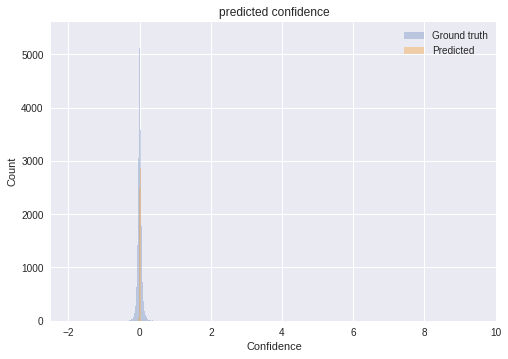

Train Acc:  0.5105047830856487
Ttrain MSE:  0.005151873689715905


In [15]:
train_acc, train_mse = calc_acc(market_train_idx)
print('Train Acc: ', train_acc)
print('Ttrain MSE: ', train_mse)

Predictions size:  299911
y_test size: 299911


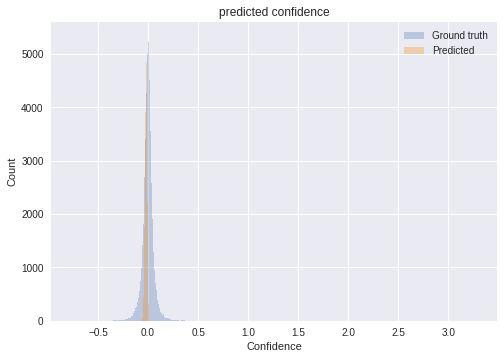

Val Acc:  0.5142158840456001
Val MSE:  0.004206466552605555


In [16]:
val_acc, val_mse = calc_acc(market_val_idx)
print('Val Acc: ', val_acc)
print('Val MSE: ', val_mse)

Predictions size:  299911
y_test size: 299911


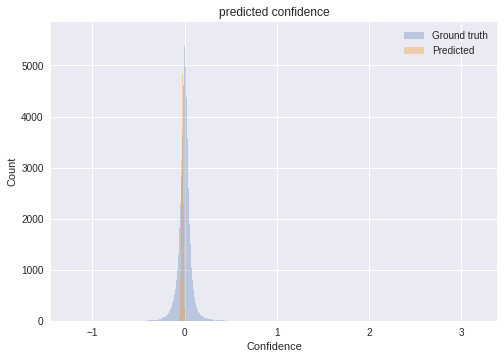

Test Acc:  0.499021376341648
Test MSE:  0.0064125079864110306


In [17]:
test_acc, test_mse = calc_acc(market_test_idx)
print('Test Acc: ', test_acc)
print('Test MSE: ', test_mse)